오늘 만들 RAG + Chain

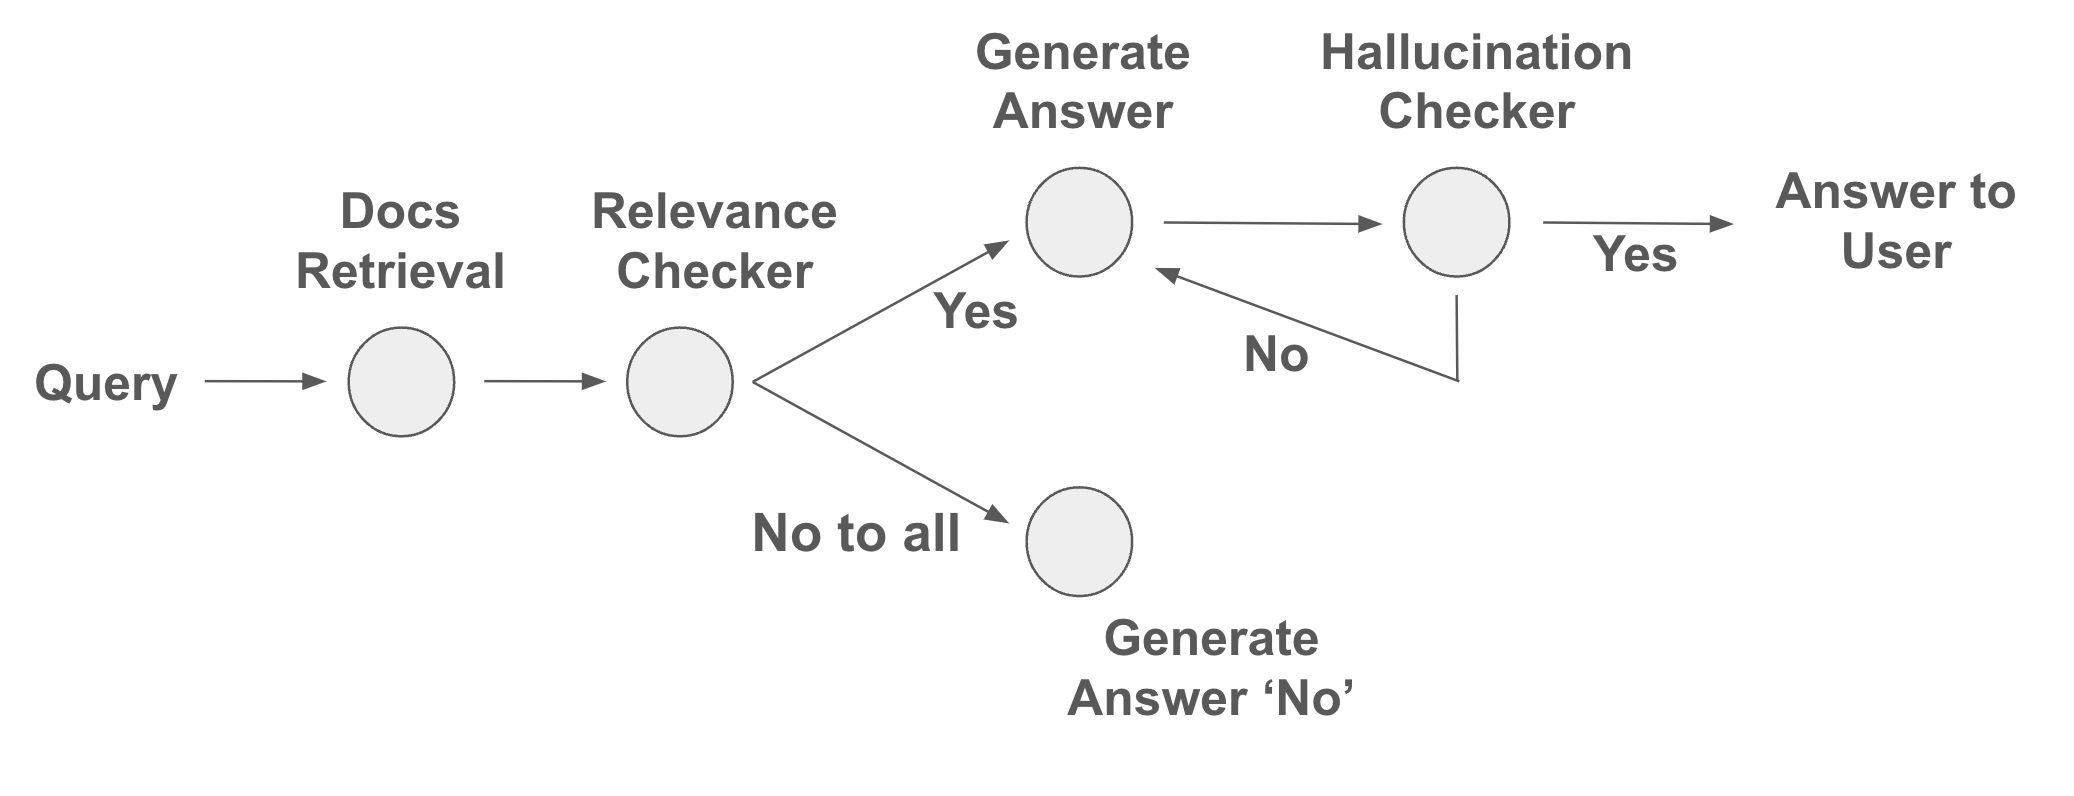

프레임워크
- Langchain
- 비슷한 역할을 하는 Llamaindex 등이 있는데, 학습 단계에서는 이들이 유용하지만, 실제 서빙을 위한 서비스를 개발하다 보면 하나 둘 직접 구현하게 되는 경우가 많음.

모델
- gpt-4o-mini
- Langchain ChatOllama 를 활용하면 Langchain 위에 첫날 실습한 Ollama + Local model 을 활용해서 구현할 수 있음

In [3]:
%%capture --no-stderr
%pip install langchain langchain-openai langchain-openai langchain_chroma langchain-text-splitters langchain_community

In [5]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [10]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

**기본 RAG tutorial**

Langchain 에 익숙하지 않으신 분은 아래 링크의 튜토리얼 코드를 한 번 읽어보시고 그 다음 과정을 진행해주세요.

https://python.langchain.com/v0.2/docs/tutorials/rag/


In [9]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "filler context", "question": "What is the capital of France?"}
).to_messages()

print(example_messages)

/Users/kakao/development/2024_gpt_learning/my_venv/lib/python3.10/site-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: What is the capital of France? \nContext: filler context \nAnswer:", additional_kwargs={}, response_metadata={})]


output JSON formatting

In [11]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [13]:

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
splits[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refin

In [14]:
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())
vectorstore

In [98]:

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("아이브 관련 채팅방 알려줘")

/Users/kakao/development/2024_gpt_learning/my_venv/lib/python3.10/site-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"아이브 관련 채팅방으로는 '이즈나 덕질 나야 채팅방'과 '아이브 애플뮤직 분철', 'IVE 사진나눔 방 및 다이브 소통방'이 있습니다. 또한 '아이브사진/화질좋은 사진나눔방'과 '다이브 소통방'도 있습니다."

**1. 3개의 블로그 포스팅 본문을 Load: WebBaseLoader 활용**

https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/

In [17]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

**2. 불러온 본문을 Split (Chunking) : recursive text splitter 활용**

https://python.langchain.com/v0.2/docs/how_to/recursive_text_splitter/

**3. Chunks 를 임베딩하여 Vector store 저장: openai, chroma 사용**

embedding model 은 "text-embedding-3-small" 사용

embedding: https://python.langchain.com/v0.2/docs/integrations/text_embedding/openai/

vetor store: https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/

**4. User query = ‘agent memory’ 를 받아 관련된 chunks를 retrieve**

state_of_the_union.txt 는 여기서 다운로드 받아주세요

https://github.com/hwchase17/chat-your-data/blob/master/state_of_the_union.txt

https://python.langchain.com/v0.2/docs/how_to/vectorstore_retriever/

https://api.python.langchain.com/en/latest/vectorstores/langchain_core.vectorstores.VectorStore.html#langchain_core.vectorstores.VectorStore.as_retriever

In [23]:
!pip install faiss-cpu

  Obtaining dependency information for faiss-cpu from https://files.pythonhosted.org/packages/b1/1c/f8305ad0317d1cad85ec32dc94cd9b54e9b5a27776716a56adbfa270c53d/faiss_cpu-1.9.0-cp310-cp310-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [88]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

loader = TextLoader("openchat_sample.tsv")

documents = loader.load()
text_splitter = CharacterTextSplitter("\n",chunk_size=30, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
texts

Created a chunk of size 62, which is longer than the specified 30
Created a chunk of size 31, which is longer than the specified 30
Created a chunk of size 34, which is longer than the specified 30
Created a chunk of size 33, which is longer than the specified 30
Created a chunk of size 35, which is longer than the specified 30
Created a chunk of size 54, which is longer than the specified 30
Created a chunk of size 45, which is longer than the specified 30
Created a chunk of size 54, which is longer than the specified 30
Created a chunk of size 66, which is longer than the specified 30
Created a chunk of size 32, which is longer than the specified 30
Created a chunk of size 40, which is longer than the specified 30
Created a chunk of size 34, which is longer than the specified 30
Created a chunk of size 53, which is longer than the specified 30
Created a chunk of size 44, which is longer than the specified 30
Created a chunk of size 77, which is longer than the specified 30
Created a 

[Document(metadata={'source': 'openchat_sample.tsv'}, page_content='수니🦋 강남메디갤러리ㅡ건강파트너/행복파트너'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='Class101 X 스무'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='플리들을 위한 밴드소통방🎸 #플레이브 #플리 #밴드커버 #노래 #소통 #다드루와 #보컬_건반_일렉_베이스_드럼_'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='🐳 고래 네패스 단톡방'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content="'방구석 해외여행 한달살이' 프로젝트 (넥제니여행영어)"),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='둥지수산(멸치액젓,갈치판매) #남해#남해갈치#남해젓갈#남해멸치'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='💛첫만미💛\xa0(첫만남이\xa0미니언즈특별전인\xa0건에 대하여)'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='틸라 풋볼 해축 채팅방 해축 이적소식, 짤, 직관영상 공유방'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='AP\xa0UNION #아모레\n3️⃣간호과정 3조'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='아모비 효밍 #아모비 

In [89]:
len(documents)

1

In [90]:
len(texts)

7992

In [95]:
[doc.page_content for doc in texts if "아이브" in doc.page_content]

['아이돌 소통방 #아이브 #뉴진스 #이즈나 #엔믹스 #키스오프라이프 #에스파 #아일릿 #미야오',
 '💝다브즈💝-다이브들을 위한 방 다이브들을 위한 방! 참코는 아이브 CRUSH뮤비 공개일 입니다!',
 '아이브 러버들 아이브',
 '포장영상 공유 방! #투바투 #아이브 #모아 #다이브 #포장영상나눔!',
 '໒꒰ྀི다이브나물즈 ꒱ྀིა #장원영 #아이브 #원영 #다이브 #멤차X #카프_실프_칼강퇴 #틱톡 #로블록스 #게임 #소통 #방_닉도금_2024_7월_28일 #다이브나물즈',
 '덕질에 미친 잡덕/팬들의 소통방😎 #잡덕 #방탄 #투바투 #투어스 #세븐틴 #엔믹스 #아이브 #아일릿 #뉴진스',
 '워뇨즈🐰🎀 안티 가주세요.#스밍#아이브',
 '다이브 소통방 #아이브#다이브#욕X#도배X#💗',
 '🌳잡덕의 숲🌳 #nct #라이즈 #투어스 #보넥도 #제베원 #세븐틴 #투바투 #에스파 #아이브 #르세라핌 #뉴진스 #아일릿',
 '도무송[프리쿠라] 만들어드려요 / 4~5일 걸립니다ㅏ #도무송 #도무송_만들어드려요 #프리쿠라 #만듬 #아이브 #여돌만_가능 #아이돌 #뉴진스 #르세라핌 #엔믹스 #아이들',
 '기억(시간체크방) \n두잇즈🐭 #아이브 #다이브 #즈',
 '아이브 소통방!🍀💓 #원영🐰#가을🦥#유진🐶#레이🐥#리즈🐱 #이서🐯  안고독한 아이브 소통방💗',
 '다이브 소통방 멤차 안해요#가을 원영 이서 유진 리즈 레이#아이브 #소통방#다이브#',
 '아이브사진/화질좋은 사진나눔방',
 '다이브 모여라!! #아이브#다이브 모여라!!#모집',
 '6/22-30 아이브 3차 럭키드로우',
 '𝑰𝑨𝑴샵 #대타X #에스파 #아이브 #들낙X',
 'NEAT ent #NEATent #가상엔터 #커보계 #서바이벌 #아이브 #장벽_낮음 #누구든_환영 #언제든지_모집 #틱톡 #유튜브',
 '‧₊ ͙ࣳ ‧𐙚𝐬𝐰𝐚𝐧#🦢𖥔 ͙ࣳ  ∿ ݁ #백조 #𝐬𝐰𝐚𝐧 #키티뽀샤 #카프실프칼강 #옾프 #이방제외모두짭 #잡덕즈 #에스파 #아이들 #아이브 #르세라핌제외',
 '💕고독한 IVE 장원영

In [100]:
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(texts, embeddings)

retriever = vectorstore.as_retriever(search_type="similarity_score_threshold",
    search_kwargs={'score_threshold': 0.3})

docs = retriever.invoke("아이브 관련 채팅방은?")
docs

[Document(metadata={'source': 'openchat_sample.tsv'}, page_content='이즈나 덕질 나야 채팅방 \n아이브 애플뮤직 분철'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='아이브사진/화질좋은 사진나눔방'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='IVE 사진나눔 방 및 다이브 소통방'),
 Document(metadata={'source': 'openchat_sample.tsv'}, page_content='다이브 소통방 #아이브#다이브#욕X#도배X#💗')]

In [26]:
# Retrieve more documents with higher diversity
# Useful if your dataset has many similar documents
vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={'k': 6, 'lambda_mult': 0.25}
)

# Fetch more documents for the MMR algorithm to consider
# But only return the top 5
vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={'k': 5, 'fetch_k': 50}
)

# Only retrieve documents that have a relevance score
# Above a certain threshold
vectorstore.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={'score_threshold': 0.8}
)

# Only get the single most similar document from the dataset
vectorstore.as_retriever(search_kwargs={'k': 1})

# Use a filter to only retrieve documents from a specific paper
vectorstore.as_retriever(
    search_kwargs={'filter': {'paper_title':'GPT-4 Technical Report'}}
)

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x3054b7640>, search_kwargs={'k': 1})

In [99]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
rag_chain.invoke("아이브 관련 채팅방 알려줘")

'아이브 관련 채팅방으로는 "이즈나 덕질 나야 채팅방", "다이브 소통방", 그리고 "아이브 사진/화질 좋은 사진 나눔방"이 있습니다. 이 방들은 아이브 팬들이 소통하고 사진을 나누는 공간입니다.'

In [102]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [112]:
from langchain_core.prompts import PromptTemplate

from langchain_core.output_parsers import JsonOutputParser
"""다음 맥락을 사용하여 마지막 질문에 답하십시오.
만약 관련있는 맥락이 하나도 없다면, 모른다고 말하십시오.
관련있는 맥락이 있다면, 관련있는 것만 사용하여 질문에 답하십시오"""
template = """다음 맥락이 관련있는지 여부를 평가하세요
항목마다 관련여부를 yes, no 값으로 json 포맷으로 출력하세요


{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)
template2 = """맥락이 yes인것이 1개라도 있다면, 답변을 생성하세요


{context}

Question: {question}

Helpful Answer:""" 
custom_rag_prompt2 = PromptTemplate.from_template(template2)
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | custom_rag_prompt
    | llm
    | StrOutputParser()
)
rag_chain.invoke("아이브 관련 채팅방 알려줘")

'```json\n{\n  "이즈나 덕질 나야 채팅방": "yes",\n  "아이브 애플뮤직 분철": "no",\n  "IVE 사진나눔 방 및 다이브 소통방": "yes",\n  "아이브사진/화질좋은 사진나눔방": "yes",\n  "다이브 소통방 #아이브#다이브#욕X#도배X#💗": "yes"\n}\n```'

**5. User query와 retrieved chunk 에 대해 relevance 가 있는지를 평가하는 시스템 프롬프트 작성: retrieval 퀄리티를 LLM 이 스스로 평가하도록 하고, 관련이 있으면 {‘relevance’: ‘yes’} 관련이 없으면 {‘relevance’: ‘no’} 라고 출력하도록 함. ( JsonOutputParser() 를 활용 )**


RAG 용 프롬프트 작성을 위한 Prompt Hub 활용

https://smith.langchain.com/hub/rlm/rag-prompt

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
prompt

In [ ]:
example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

output JSON formatting

https://python.langchain.com/v0.2/docs/how_to/output_parser_json/#without-pydantic

In [ ]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

joke_query = "Tell me a joke."

parser = JsonOutputParser()

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | llm | parser

chain.invoke({"query": joke_query})

```
{'response': "Sure! Here's a joke for you: Why couldn't the bicycle stand up by itself? Because it was two tired!"}
```

6. 5 에서 모든 docs에 대해 ‘no’ 라면 디버깅 (Splitter, Chunk size, overlap, embedding model, vector store, retrieval 평가 시스템 프롬프트 등)

7. 5에서 ‘yes’ 라면 질문과 명확히 관련 없는 docs 나 질문 (예: ‘I like an apple’)에 대해서는 ‘no’ 라고 나오는지 테스트 프롬프트 및 평가 코드 작성. 이 때는 관련 없다는 답변 작성

8. ‘yes’ 이고 7의 평가에서도 문제가 없다면, 4의 retrieved chunk 를 가지고 답변 작성
prompt | llm | parser 코드 작성

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("What is Task Decomposition?"):
    print(chunk, end="", flush=True)

9. 생성된 답안에 Hallucination 이 있는지 평가하는 시스템 프롬프트 작성. LLM이 스스로 평가하도록 하고, hallucination 이 있으면 {‘hallucination’: ‘yes’} 없으면 {‘hallucination’: ‘no’} 라고 출력하도록 함

10. 9 에서 ‘yes’ 면 8 로 돌아가서 다시 생성, ‘no’ 면 답변 생성하고 유저에게 답변 생성에 사용된 출처와 함께 출력 (최대 2번까지 다시 생성)

11. https://applied-llms.org/ 링크는 llm 을 이용해 1년간 개발해 본 팀이 배운 것들을 정리한 아티클 입니다.

저자의 생각을 묻는 질문들에 답하기 위해서

1) Chunking & embedding & storing

2) Load

3) Retrieval

4) Generation

으로 구성된 RAG 코드를 작성하고 아래 예시 질문에 대한 답을 해보세요.

예시)
RAG 에 대한 저자의 생각은 무엇인가?
RAG 와 fine tuning 에 대해 저자는 어떻게 비교하고 있나?
저자가 가장 많은 부분을 할당해 설명하는 개념은 무엇인가?

11 실습을 마치지 못했더라도, https://applied-llms.org/ 아티클은 꼭 읽어 보시기를 추천 드립니다.